## 09-ResNet

[1.Load Mammal Dataset](#1)
- [1-1.Define Dataset Class](#1-1)
- [1-2.Define DataLoader](#1-2)

[2.Plain Network](#2)
- [2-1.Plain BasicBlock](#2-1)
- [2-2.Plain BottleNeckBlock](#2-2)
- [2-3.Plain Network](#2-3)

[3.Residual Learning Network](#3)
- [3-1.Residual BasicBlock](#3-1)
- [3-2.Residual BottleNeckBlock](#3-2)
- [3-3.ResNet](#3-3)

[4.Training](#4)
- [4-1.Define Functions](#4-1)
- [4-2.Train Plain Network](#4-2)
- [4-3.Train ResNet](#4-3)

In [1]:
import os
import cv2
import torch
import albumentations as A
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torchsummary import summary
from torch.nn import functional as F
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
data_dir = "/home/pervinco/Datasets/mammals-classification/data"
save_dir = "./runs/mammal-classification/resnet"

epochs = 500
batch_size = 64
learning_rate = 0.0001 ## 0.0001
lr_patience = 10
lr_decay_factor = 0.1
weight_decay = 0.1 ## 0.09
momentum = 0.9

num_workers = os.cpu_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id="1"></a>
## 1. Load Mamal Dataset

<a id="1-1"></a>
### 1-1.Define Dataset Class

[https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals](https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals)

In [3]:
classes = sorted(os.listdir(data_dir))
print(classes)

['african_elephant', 'alpaca', 'american_bison', 'anteater', 'arctic_fox', 'armadillo', 'baboon', 'badger', 'blue_whale', 'brown_bear', 'camel', 'dolphin', 'giraffe', 'groundhog', 'highland_cattle', 'horse', 'jackal', 'kangaroo', 'koala', 'manatee', 'mongoose', 'mountain_goat', 'opossum', 'orangutan', 'otter', 'polar_bear', 'porcupine', 'red_panda', 'rhinoceros', 'sea_lion', 'seal', 'snow_leopard', 'squirrel', 'sugar_glider', 'tapir', 'vampire_bat', 'vicuna', 'walrus', 'warthog', 'water_buffalo', 'weasel', 'wildebeest', 'wombat', 'yak', 'zebra']


In [4]:
images, labels = [], []
for str_label in classes:
    img_files = os.listdir(f"{data_dir}/{str_label}")
    for file in img_files:
        if file.endswith(".jpg"):
            images.append(f"{data_dir}/{str_label}/{file}")
            labels.append(str_label)

print(f"Num of Classes : {len(classes)}")
print(f"Num of files & labels : {len(images)}, {len(labels)}")
print(images[0])

Num of Classes : 45
Num of files & labels : 13751, 13751
/home/pervinco/Datasets/mammals-classification/data/african_elephant/african_elephant-0125.jpg


In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=42)

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

12375 12375
1376 1376


In [6]:
class PetDataset(Dataset):
    def __init__(self, images, labels, classes, mean=None, std=None, augmentation=False):
        self.classes = classes
        self.images = images
        self.labels = labels

        if mean is None:
            mean = (0.485, 0.456, 0.406)

        if std is None:
            std = (0.229, 0.224, 0.225)

        if augmentation:
            self.augmentation = A.Compose([
                A.OneOf([
                    A.Resize(224, 224, p=0.5),
                    A.SmallestMaxSize(max_size=[256, 512], p=0.5)
                ], p=1),
                A.RandomCrop(width=224, height=224),

                A.HorizontalFlip(p=0.4),
                A.RGBShift(p=0.3),

                A.ShiftScaleRotate(p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), 
                                   scale_limit=(-0.099, 0.100), 
                                   rotate_limit=(-180, 180), 
                                   interpolation=0, 
                                   border_mode=0, 
                                   value=(0, 0, 0)),
                A.RandomBrightnessContrast(p=1.0, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
                A.AdvancedBlur(p=0.35, blur_limit=(3, 7), 
                               sigmaX_limit=(0.2, 1.0), 
                               sigmaY_limit=(0.2, 1.0), 
                               rotate_limit=(-90, 90), 
                               beta_limit=(0.5, 8.0), 
                               noise_limit=(0.9, 1.1)),

                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])
        else:
            self.augmentation = A.Compose([
                A.Resize(224, 224, p=1),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.classes.index(label)

        image = self.augmentation(image=image)["image"]

        return image, label

In [7]:
train_dataset = PetDataset(train_x, train_y, classes, augmentation=True)
valid_dataset = PetDataset(valid_x, valid_y, classes, augmentation=False)

<a id="1-2"></a>
### 1-2.Define DataLoader

In [8]:
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)

<a id="2"></a>
## 2.Build Plain Network

<a id="2-1"></a>
### 2-1.Plain BasicBlock

In [9]:
class PlainBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

<a id="2-2"></a>
### 2-2.Plain BottleNeck Block

In [10]:
class PlainBottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        return x

<a id="2-3"></a>
### 2-3.Plain Network

In [11]:
class PlainNet(nn.Module):
    def __init__(self, model_name="plainnet18", num_classes=1000):
        super().__init__()
        self.in_channels = 64
        configs = {"plainnet18" : [2, 2, 2, 2],
                   "plainnet34" : [3, 4, 6, 3],
                   "plainnet50" : [3, 4, 6, 3],
                   "plainnet101" : [3, 4, 23, 3],
                   "plainnet152" : [3, 8, 36, 3]}
        
        config = configs[model_name]
        if model_name in ["plainnet18", "plainnet34"]:
            block = PlainBasicBlock
        else:
            block = PlainBottleneck

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, config[0], stride=1)
        self.layer2 = self._make_layer(block, 128, config[1], stride=2)
        self.layer3 = self._make_layer(block, 256, config[2], stride=2)
        self.layer4 = self._make_layer(block, 512, config[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

<a id="3"></a>
## 3.Residual Learning Network

<a id="3-1"></a>
### 3-1.Residual BasicBlock

In [12]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.stride = stride
        self.downsample = downsample

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


<a id="3-2"></a>
### 3-2.Residual BottleNeckBlock

In [13]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.stride = stride
        self.downsample = downsample
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

<a id="3-3"></a>
### 3-3.ResNet

In [14]:
class ResNet(nn.Module):
    def __init__(self, model_name, num_classes=1000):
        super().__init__()
        configs = {"resnet18" : [2, 2, 2, 2],
                   "resnet34" : [3, 4, 6, 3],
                   "resnet50" : [3, 4, 6, 3],
                   "resnet101" : [3, 4, 23, 3],
                   "resnet152" : [3, 8, 36, 3]}
        
        if model_name in ["resnet18", "resnet34"]:
            block = BasicBlock
        else:
            block = Bottleneck
        
        config = configs[model_name]
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, config[0])
        self.layer2 = self.make_layer(block, 128, config[1], stride=2)
        self.layer3 = self.make_layer(block, 256, config[2], stride=2)
        self.layer4 = self.make_layer(block, 512, config[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

<a id="4"></a>
## 4.Training

<a id="4-1"></a>
### 4-1.Define Functions

In [15]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_cost, train_acc = 0.0, 0.0
    for x, y in tqdm(dataloader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        cost = criterion(y_pred, y)
        cost.backward()
        optimizer.step()

        train_cost += cost.item() * x.size(0)

        _, pred_labels = torch.max(y_pred, 1)
        train_acc += (pred_labels == y).sum().item()

    train_cost /= len(dataloader.dataset)
    train_acc /= len(dataloader.dataset)

    return train_cost, train_acc


def valid(model, dataloader, criterion, device):
    model.eval()

    valid_cost, valid_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Valid", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            cost = criterion(y_pred, y)

            valid_cost += cost.item() * x.size(0)

            _, pred_labels = torch.max(y_pred, 1)
            valid_acc += (pred_labels == y).sum().item()

        valid_cost /= len(dataloader.dataset)
        valid_acc /= len(dataloader.dataset)

    return valid_cost, valid_acc

<a id="4-2"></a>
### 4-2.Train Plain Network

In [16]:
plain_model = PlainNet("plainnet34", num_classes=len(classes))
plain_model = plain_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(plain_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_patience, verbose=True)

train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
early_stop_counter = 0
early_stop_patience = 10
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(plain_model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(plain_model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

    scheduler.step(valid_cost)

Epoch : 0 | 500
	Train Loss : 3.8109, Train Acc : 0.0272
	Valid Loss : 3.7727, Valid Acc : 0.0276


Epoch : 10 | 500
	Train Loss : 3.5978, Train Acc : 0.0660
	Valid Loss : 3.5544, Valid Acc : 0.0843


Epoch : 20 | 500
	Train Loss : 3.5256, Train Acc : 0.0878
	Valid Loss : 3.4672, Valid Acc : 0.1032


Epoch : 30 | 500
	Train Loss : 3.4224, Train Acc : 0.1206
	Valid Loss : 3.3121, Valid Acc : 0.1403


Epoch : 40 | 500
	Train Loss : 3.3595, Train Acc : 0.1456
	Valid Loss : 3.2886, Valid Acc : 0.1628


Epoch : 50 | 500
	Train Loss : 3.3124, Train Acc : 0.1619
	Valid Loss : 3.2630, Valid Acc : 0.1592


Epoch : 60 | 500
	Train Loss : 3.2804, Train Acc : 0.1833
	Valid Loss : 3.1793, Valid Acc : 0.1824


Epoch : 70 | 500
	Train Loss : 3.2674, Train Acc : 0.1936
	Valid Loss : 3.2028, Valid Acc : 0.1846


Early stopping triggered after epoch 75 due to no improvement in validation loss


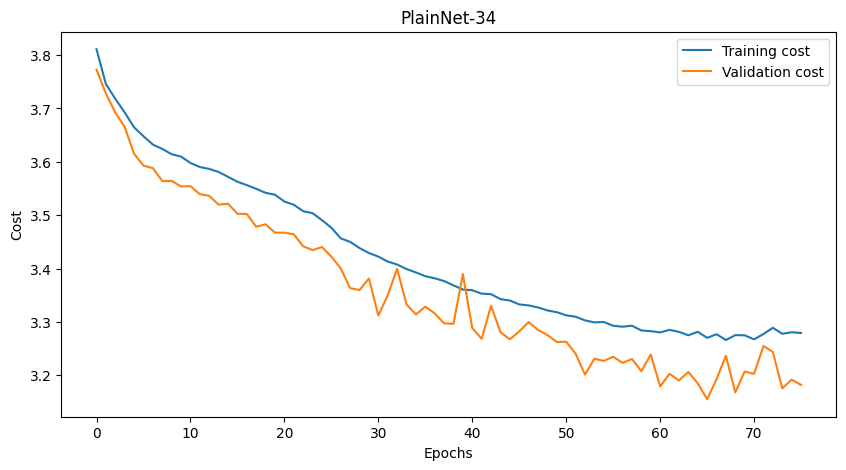

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.title('PlainNet-34')
plt.show()

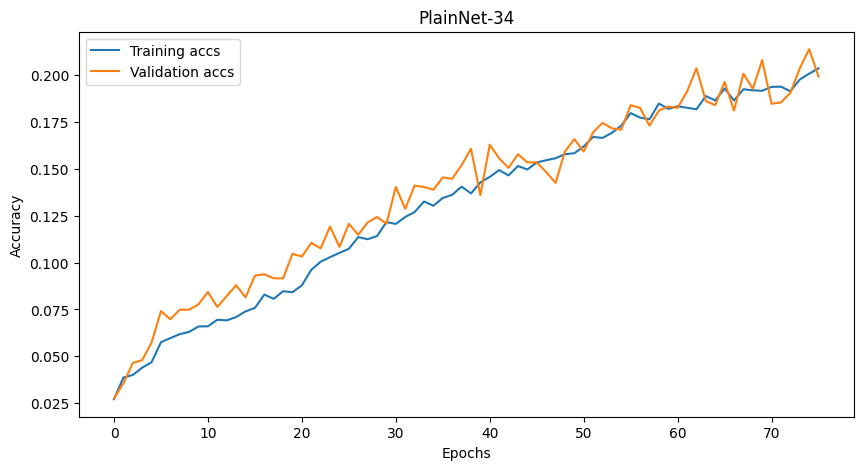

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('PlainNet-34')
plt.show()

In [19]:
plain_model = PlainNet("plainnet50", num_classes=len(classes))
plain_model = plain_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(plain_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_patience, verbose=True)

train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
early_stop_counter = 0
early_stop_patience = 10
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(plain_model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(plain_model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

    scheduler.step(valid_cost)

Epoch : 0 | 500
	Train Loss : 3.8124, Train Acc : 0.0278
	Valid Loss : 3.8080, Valid Acc : 0.0203


Epoch : 10 | 500
	Train Loss : 3.7680, Train Acc : 0.0406
	Valid Loss : 3.7606, Valid Acc : 0.0458


Epoch : 20 | 500
	Train Loss : 3.6366, Train Acc : 0.0620
	Valid Loss : 3.5921, Valid Acc : 0.0756


Epoch : 30 | 500
	Train Loss : 3.5575, Train Acc : 0.0750
	Valid Loss : 3.5148, Valid Acc : 0.0836


Epoch : 40 | 500
	Train Loss : 3.5050, Train Acc : 0.0878
	Valid Loss : 3.4794, Valid Acc : 0.0901


Epoch : 50 | 500
	Train Loss : 3.4690, Train Acc : 0.0969
	Valid Loss : 3.3916, Valid Acc : 0.1148


Epoch : 60 | 500
	Train Loss : 3.4264, Train Acc : 0.1101
	Valid Loss : 3.4073, Valid Acc : 0.1126


Epoch : 70 | 500
	Train Loss : 3.3994, Train Acc : 0.1215
	Valid Loss : 3.3688, Valid Acc : 0.1279


Epoch : 80 | 500
	Train Loss : 3.3855, Train Acc : 0.1325
	Valid Loss : 3.3199, Valid Acc : 0.1424


Epoch : 90 | 500
	Train Loss : 3.3817, Train Acc : 0.1381
	Valid Loss : 3.3164, Valid Acc : 0.1548


Early stopping triggered after epoch 96 due to no improvement in validation loss


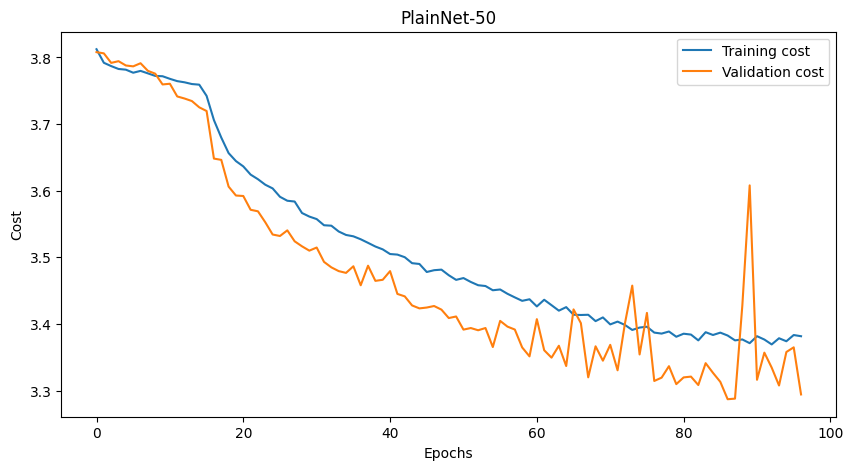

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.title('PlainNet-50')
plt.show()

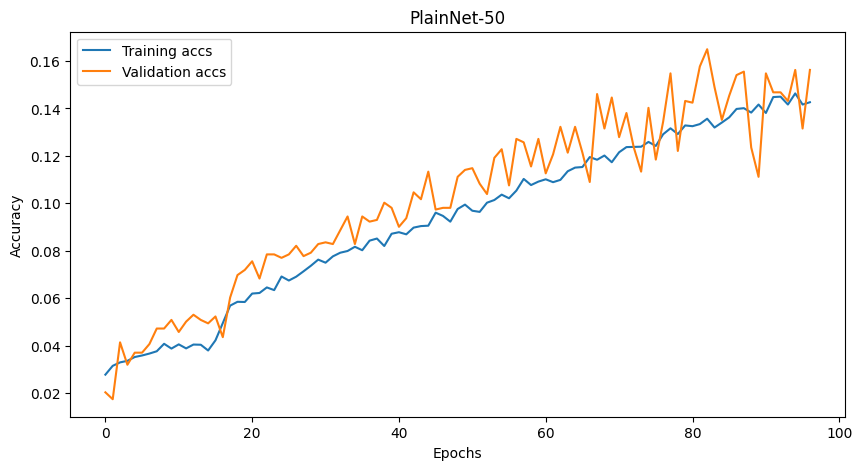

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('PlainNet-50')
plt.show()

<a id="4-3"></a>
### 4-3.Train ResNet

In [22]:
residual_model = ResNet("resnet34", num_classes=len(classes))
residual_model = residual_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(residual_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_patience, verbose=True)

train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
early_stop_counter = 0
early_stop_patience = 10
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(residual_model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(residual_model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

    scheduler.step(valid_cost)

Epoch : 0 | 500
	Train Loss : 3.8059, Train Acc : 0.0423
	Valid Loss : 3.7112, Valid Acc : 0.0705


Epoch : 10 | 500
	Train Loss : 3.1955, Train Acc : 0.1710
	Valid Loss : 3.1212, Valid Acc : 0.1773


Epoch : 20 | 500
	Train Loss : 3.0024, Train Acc : 0.2145
	Valid Loss : 2.9106, Valid Acc : 0.2362


Epoch : 30 | 500
	Train Loss : 2.8156, Train Acc : 0.2576
	Valid Loss : 2.7946, Valid Acc : 0.2471


Epoch : 40 | 500
	Train Loss : 2.6663, Train Acc : 0.2963
	Valid Loss : 2.4707, Valid Acc : 0.3336


Epoch : 50 | 500
	Train Loss : 2.5185, Train Acc : 0.3383
	Valid Loss : 2.4282, Valid Acc : 0.3626


Epoch : 60 | 500
	Train Loss : 2.4221, Train Acc : 0.3716
	Valid Loss : 2.3851, Valid Acc : 0.3488


Epoch : 70 | 500
	Train Loss : 2.3189, Train Acc : 0.4115
	Valid Loss : 2.2739, Valid Acc : 0.3910


Epoch : 80 | 500
	Train Loss : 2.2503, Train Acc : 0.4412
	Valid Loss : 2.2770, Valid Acc : 0.4048


Early stopping triggered after epoch 87 due to no improvement in validation loss


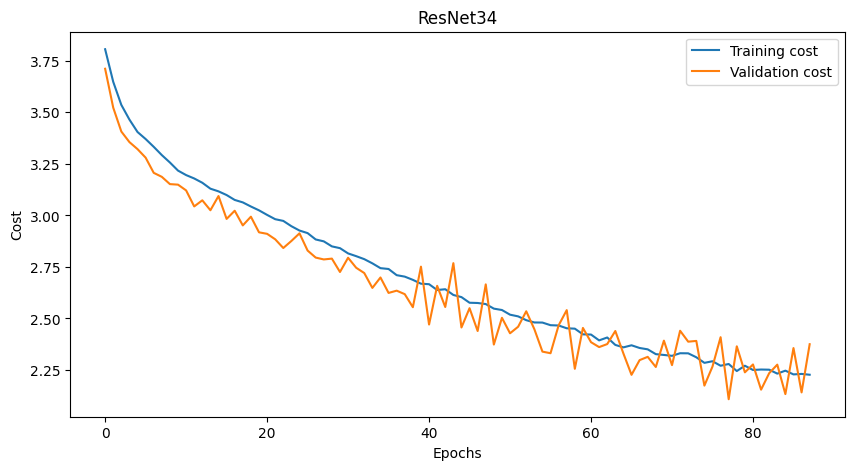

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.title('ResNet34')
plt.show()

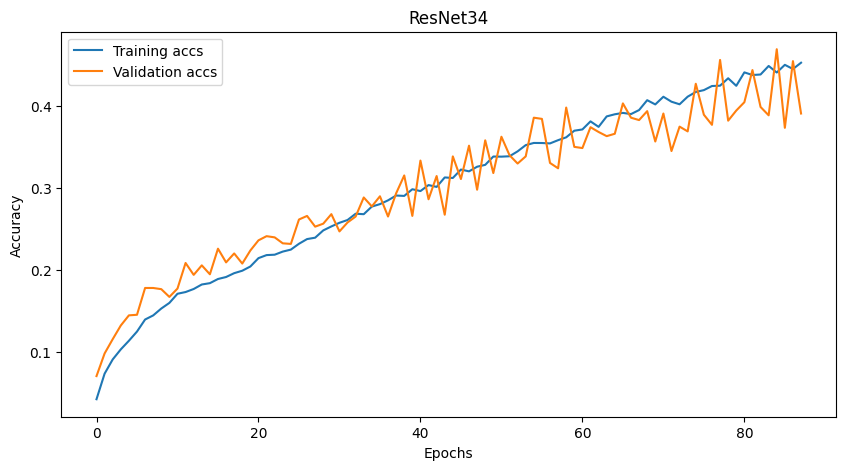

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet34')
plt.show()

In [25]:
residual_model = ResNet("resnet50", num_classes=len(classes))
residual_model = residual_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(residual_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_patience, verbose=True)

train_costs, train_accs = [], []
valid_costs, valid_accs = [], []
early_stop_counter = 0
early_stop_patience = 10
best_valid_cost = float('inf')
for epoch in range(epochs):
    train_cost, train_acc = train(residual_model, train_dataloder, criterion, optimizer, device)
    valid_cost, valid_acc = valid(residual_model, valid_dataloader, criterion, device)

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch : {epoch} | {epochs}")
        print(f"\tTrain Loss : {train_cost:.4f}, Train Acc : {train_acc:.4f}")
        print(f"\tValid Loss : {valid_cost:.4f}, Valid Acc : {valid_acc:.4f}")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    ## Early Stopping
    if valid_cost < best_valid_cost:
        best_valid_cost = valid_cost
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after epoch {epoch} due to no improvement in validation loss")
        break  # Break out of the loop to stop training

    scheduler.step(valid_cost)

Epoch : 0 | 500
	Train Loss : 3.8072, Train Acc : 0.0335
	Valid Loss : 3.7766, Valid Acc : 0.0472


Epoch : 10 | 500
	Train Loss : 3.4564, Train Acc : 0.1004
	Valid Loss : 3.3621, Valid Acc : 0.1265


Epoch : 20 | 500
	Train Loss : 3.2913, Train Acc : 0.1494
	Valid Loss : 3.2055, Valid Acc : 0.1722


Epoch : 30 | 500
	Train Loss : 3.1026, Train Acc : 0.1935
	Valid Loss : 3.0092, Valid Acc : 0.2108


Epoch : 40 | 500
	Train Loss : 2.9751, Train Acc : 0.2173
	Valid Loss : 2.9009, Valid Acc : 0.2333


Epoch : 50 | 500
	Train Loss : 2.8231, Train Acc : 0.2590
	Valid Loss : 2.7001, Valid Acc : 0.2762


Epoch : 60 | 500
	Train Loss : 2.6955, Train Acc : 0.2906
	Valid Loss : 2.5848, Valid Acc : 0.3060


Epoch : 70 | 500
	Train Loss : 2.5810, Train Acc : 0.3219
	Valid Loss : 2.4816, Valid Acc : 0.3234


Epoch : 80 | 500
	Train Loss : 2.4793, Train Acc : 0.3526
	Valid Loss : 2.3069, Valid Acc : 0.3808


Epoch : 90 | 500
	Train Loss : 2.3742, Train Acc : 0.3876
	Valid Loss : 2.2013, Valid Acc : 0.4004


Epoch : 100 | 500
	Train Loss : 2.3167, Train Acc : 0.4069
	Valid Loss : 2.2094, Valid Acc : 0.4077


Epoch : 110 | 500
	Train Loss : 2.2711, Train Acc : 0.4222
	Valid Loss : 2.4711, Valid Acc : 0.3685


Epoch : 120 | 500
	Train Loss : 2.2378, Train Acc : 0.4564
	Valid Loss : 2.2620, Valid Acc : 0.4222


Early stopping triggered after epoch 124 due to no improvement in validation loss


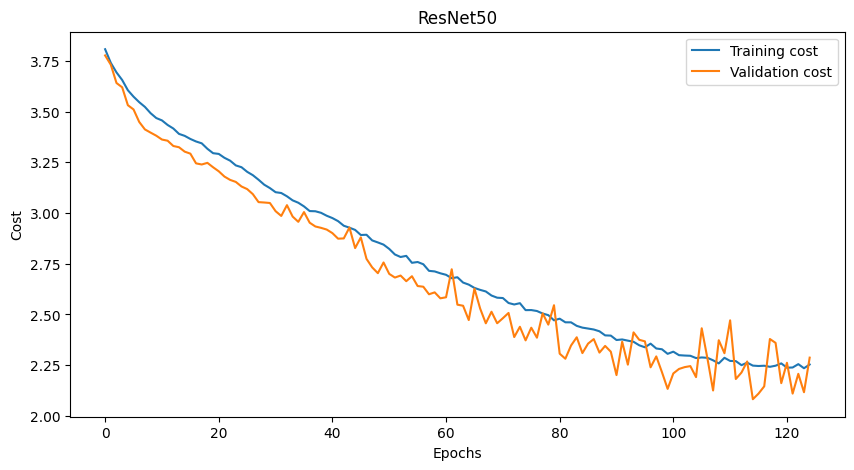

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Training cost')
plt.plot(valid_costs, label='Validation cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.title('ResNet50')
plt.show()

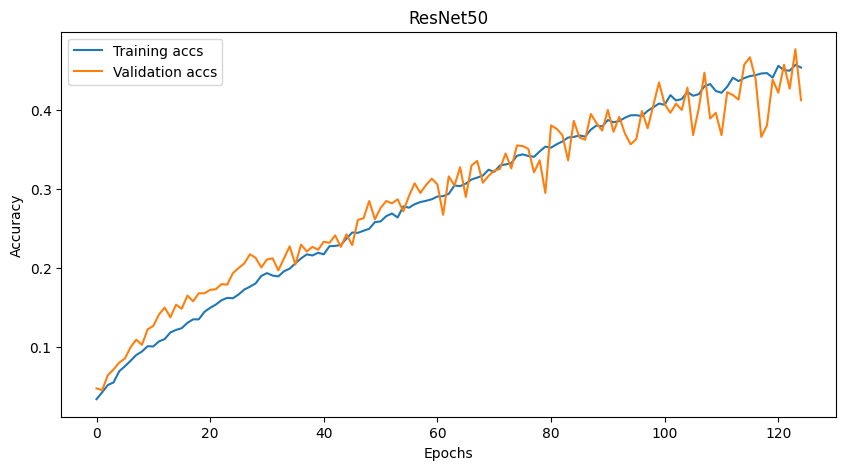

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training accs')
plt.plot(valid_accs, label='Validation accs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet50')
plt.show()